# Probability Queue Position Models

## Overview

Here, we will demonstrate how queue position models affect order fill simulation and, ultimately, the strategy's performance. It is essential for accurate backtesting to find the proper queue position modeling by comparing backtest and real trading results. In this context, we will illustrate comparisons by changing queue position models. By doing this, you can determine the appropriate queue position model that aligns with the backtesting and real trading results.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
from numba import njit
from numba.typed import Dict

from hftbacktest import BUY, SELL
from hftbacktest import (
    HftBacktest,
    Linear,
    Stat,
    GTX,
    COL_SIDE,
    COL_PRICE,
    IntpOrderLatency, 
    SquareProbQueueModel,
    LogProbQueueModel2,
    PowerProbQueueModel3
)

import numpy as np

@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

@njit(cache=True)
def compute_coeff_simplified(gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = inv_k
    c2 = np.sqrt(np.divide(gamma * np.exp(1), 2 * A * delta * k))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, stat, gamma, order_qty):
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    delta = 1
    
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                # To properly calibrate A and K, a sufficient number of data points is required, here, with a minimum of three.
                # If market trades only take place at the best bid and offer, an alternative method may be necessary 
                # to compute half spread and skew, since fitting a function might not be feasible  due to insufficient 
                # data points.
                # Alternatively, you can increase the time-step for measuring order arrivals,  
                # but this could result in a delayed response.
                half_spread_one = False
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff_simplified(gamma, delta, A, k)
        
        half_spread = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = hbt.position / order_qty
        
        bid_depth = half_spread + skew * normalized_position
        ask_depth = half_spread - skew * normalized_position

        bid_price = min(mid_price_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(mid_price_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        grid_interval = max(np.round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [2]:
def backtest(args):
    asset_name, asset_info, model = args
    
    if model == 'SquareProbQueueModel':
        queue_model = SquareProbQueueModel()
    elif model == 'LogProbQueueModel2':
        queue_model = LogProbQueueModel2()
    elif model == 'PowerProbQueueModel3':
        queue_model = PowerProbQueueModel3(3)
    else:
        raise ValueError
        
    latency_data = np.concatenate(
        [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230731, 20230732)]
    )
        
    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230731, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=queue_model,
        asset_type=Linear,
        snapshot='data/{}_20230730_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230730_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gamma = 0.00005
    gridtrading_glft_mm(hbt, stat.recorder, gamma, order_qty)

    np.savez(
        '{}_stat_000005_{}'.format(asset_name, model),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [3]:
%%capture
from multiprocessing import Pool
import json

with open('assets2.json', 'r') as f:
    assets = json.load(f)

with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'SquareProbQueueModel') for k, v in assets.items()]))
    
with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'LogProbQueueModel2') for k, v in assets.items()]))
    
with Pool(16) as p:
    print(p.map(backtest, [(k, v, 'PowerProbQueueModel3') for k, v in assets.items()]))

Text(0, 0.5, 'Cumulative Returns (%)')

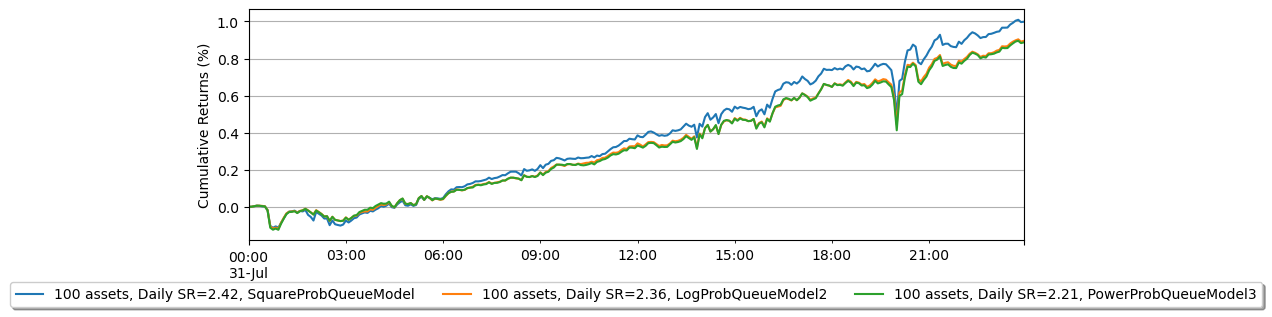

In [4]:
import pandas as pd

from matplotlib import pyplot as plt

def load_equity(model):
    equity_values = {}
    sr_values = {}
    for asset_name in assets.keys():
        stat = np.load('{}_stat_000005_{}.npz'.format(asset_name, model))
        timestamp = stat['timestamp']
        mid = stat['mid']
        balance = stat['balance']
        position = stat['position']
        fee = stat['fee']

        equity = mid * position + balance - fee
        equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
        equity_ = equity.resample('5min').last()

        pnl = equity_.diff()
        sr = np.divide(pnl.mean(), pnl.std())

        equity_values[asset_name] = equity_
        sr_values[asset_name] = sr

    sr_m = np.nanmean(list(sr_values.values()))
    sr_s = np.nanstd(list(sr_values.values()))

    asset_number = 0
    net_equity = None
    for i, (equity, sr) in enumerate(zip(equity_values.values(), sr_values.values())):
        # There are some assets that aren't working within this scheme.
        # This might be because the order arrivals don't follow a Poisson distribution that this model assumes.
        # As a result, it filters out assets whose SR falls outside -0.5 sigma.
        if (sr - sr_m) / sr_s > -0.5:
            asset_number += 1
            if net_equity is None:
                net_equity = equity.copy()
            else:
                net_equity += equity.copy()

            if asset_number == 100:
                # 2_000 is capital for each trading asset.
                return (net_equity / asset_number) / 2_000

np.seterr(divide='ignore', invalid='ignore')

fig = plt.figure()
fig.set_size_inches(10, 3)
legend = []

for model in ['SquareProbQueueModel', 'LogProbQueueModel2', 'PowerProbQueueModel3']:
    net_equity_ = load_equity(model)

    pnl = net_equity_.diff()
    sr = pnl.mean() / pnl.std() * np.sqrt(288)
    legend.append('100 assets, Daily SR={:.2f}, {}'.format(sr, model))
    (net_equity_ * 100).plot()

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')